# Model from scratch with explanation
> "A MNIST neural network classifier from scratch"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/model_scratch/model.PNG
- hide: false
- search_exclude: true

In this example we will try to code a neural net from the ground up. We will use the basics learned from the earlier examples. Specifically, this model:
![](my_icons/model.PNG)

# Steps
The steps we need to take are as follow:
1. init dataset + weights and biases2
1. calculate gradient 
    - predict the values
    - calculate the loss
    - calc. gradients + go backward
    - set the gradients to 0 so they don't add up on the next backward pass
1. calculate the accuracy

## Requirements
- a loss function
- a model
- scale everything up with fastai libs. and compare

In [ ]:
from fastai.vision.all import *
from fastbook import *

#first we need to get the images from the file
path = untar_data(URLs.MNIST_SAMPLE)
threes = (path/'train'/'3').ls() #these are paths to the files
sevens = (path/'train'/'7').ls()

#then we put them into tensors
threes_tensors = [tensor(Image.open(o)) for o in threes]
sevens_tensors = [tensor(Image.open(o)) for o in sevens]
threes_tensors[0][4:30][4:30], show_image(threes_tensors[0])

As you can see, printing a value from threes_tensors we get a tensor with the value of each pixel. The form resembles a three.

In [31]:
#the next step is to stack the threes and sevens together so we can get a simple array
stacked_threes = torch.stack(threes_tensors).float()/255
stacked_sevens = torch.stack(sevens_tensors).float()/255
stacked_threes[0][10:20,10:20], stacked_threes.shape
#now we can see the values are scaled between 0 and 1

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.9882, 0.9882, 0.9882, 0.8078],
         [0.0000, 0.0000, 0.2471, 0.3686, 0.8510, 0.9922, 0.7412, 0.6196, 0.1373, 0.0784],
         [0.0000, 0.3882, 0.9490, 0.9647, 0.8431, 0.2824, 0.0392, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.9922, 0.9882, 0.5176, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.7529, 0.9922, 0.9098, 0.1843, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.3059, 0.9490, 0.9882, 0.9098, 0.1647, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.4039, 0.9451, 0.9882, 0.8706, 0.2235, 0.0431, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.3843, 0.9882, 0.9922, 0.9882, 0.2784, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.9922, 0.9098, 0.1843, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3843, 0.7843, 0.9882, 0.9098, 0.0000]]),
 torch.Size([6131, 28, 28]))

the shape is what defins a tensor. We have 6131 images of 28 * 28 height and width. We changed it from an image to a rank 3 tensor. This will provide extremly useful later.

Now, we will be using <b> SGD - stochastic gradient descent </b> to teach the model to learn. 
## Steps

1. *Initialize* the weights.
1. For each image, use these weights to *predict* whether it appears to be a 3 or a 7.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

In [32]:
#now we can finally get the final parameters that we will use
train_x = torch.cat((stacked_threes, stacked_sevens)).view(-1,28*28)


#we changed the rank of the tensor from 3 to 2 using view.
#Why? Because it's easier to work with
train_x.shape, train_x[0,:100]

(torch.Size([12396, 784]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [33]:
#now we need a label for 3 and 7. We will use 1 for 3 and 0 for 7
#so the model will predict 1 if it's a 3 and a 0 if it's a 7
train_y = tensor([1]*len(stacked_threes) + [0]*len(stacked_sevens))
print(train_y.shape)
#currently we have an array of 1s and 0s that represent all the 3s and 7s in the training set. 
#but we need a 2D array, that's required from pytorch so we use unsqueeze
train_y = train_y.unsqueeze(1)
train_y.shape

torch.Size([12396])


torch.Size([12396, 1])

In [34]:
#so the final vars. will be
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [35]:
#do the same for the validation set

valid_threes = (path/'valid'/'3').ls()
valid_sevens = (path/'valid'/'7').ls()
valid_threes_tensors = [tensor(Image.open(o)) for o in valid_threes]
valid_sevens_tensors = [tensor(Image.open(o)) for o in valid_sevens]

valid_threes_tensors = torch.stack(valid_threes_tensors).float()/255
valid_sevens_tensors = torch.stack(valid_sevens_tensors).float()/255

valid_x = torch.cat((valid_threes_tensors, valid_sevens_tensors)).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_threes_tensors) + [0] * len(valid_sevens_tensors)).unsqueeze(1)

valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [36]:
#we can now get the full dataset
dset = list(zip(train_x, train_y))
x, y = dset[0]

valid_dset = list(zip(valid_x, valid_y))

x.shape, y # x -> image, y -> label of that image

(torch.Size([784]), tensor([1]))

In [37]:
#now we need to initialize the parameters with random values
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
#we also need .requires_grad_ so that it knows we want back propagation + we want it in place

#init. weights
weights = init_params((28 * 28,1)) # we init. a weight for every pixel
bias = init_params(1)
weights.shape, bias.shape # we need this shape later


(torch.Size([784, 1]), torch.Size([1]))

We have finally finished the first step in our model: initializing the random values which will change in time.
# initialize - complete

# predicting
The next step is to predict what the value is. How do we do that? We multiply the matrices together. By doing that we get the prediction based on the weights assigned to it.

In [38]:
(train_x[0] * weights.T).sum() + bias

tensor([1.0124], grad_fn=<AddBackward0>)

This is the predicted value for the first image. But what we need is the prediction for the whole dataset. We can't use for loops(since they are extremly slow, but we can use broadcasting).

In [39]:
#creating a function that does that for us.
def linear1(xb): return xb@weights + bias

predictions = linear1(train_x)
predictions

tensor([[ 1.0124],
        [12.9530],
        [ 2.6870],
        ...,
        [13.2774],
        [ 4.4847],
        [ 9.8195]], grad_fn=<AddBackward0>)

As we can see, the first predictions match showing that our math was correct. 
### So, we calculated the prediction using the linear function.
The next step is to calculate the loss

# Calculating the loss

In [40]:
correct = (predictions > 0.0).float() == train_y
correct.float().mean().item() # this returns the accuracy of the model

0.5086318254470825

As we expected, the accuracy of the model is <b> BAD </b>.

AND we can't use the accuracy of the model as the loss functions since a small change in the weights will, most likely, not change the accuracy, so we need another loss function.

In [41]:
def sigmoid(x): return 1/(1+torch.exp(-x))

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1,1-predictions,predictions).mean()

mnist_loss(predictions, train_y).item()

0.4906861484050751

Of course, the loss function is 1 - the accuracy. Now that we have finished the loss step of the road, the next thing we need to do is <b> optimization </b>.

# Optimization
In order to optimize we use batches. What are batches? 

<b> Batches </b> are chunks of data. We could train the model for the whole dataset, but it would take a lot of time. And we could also train the model on a single piece of data train_x[0], but that will not produce very  accurate results. So, by having this compromise we can take "the good" from both methods. 

DataLoader already has a batch_size parameter. That being said, we can start implementing everything up until now in a more concise way.


Putting it all together
--
- init parameters
- init dataLoader: dset + batch_size
- create a func. that does prediction, loss and gradient for us

In [42]:
#params
weights = init_params((28*28,1))
bias = init_params(1)

#dataloader
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    
    #why LOSS.backward()? because we need to calculate loss'(train_x). That is the gradient

xb, yb = first(dl)
calc_grad(xb, yb, linear1)
print(weights.grad.mean(),bias.grad)
weights.grad.zero_()
bias.grad.zero_()

tensor(-0.0093) tensor([-0.0705])


tensor([0.])

In [43]:
#by putting this last cell together we get a function
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()
            
#now we need a function to tell us the accuracy of the model
# xb is actually model(xb)
def batch_accuracy(xb, yb):
    preds = sigmoid(xb)
    corrects = (preds>0.5) == yb
    return corrects.float().mean()

def validate_epoch(model):
    acc = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return torch.stack(acc).mean()


#now let's try to train for an epoch and see if there is any change
lr=1.0
params = weights,bias
print(validate_epoch(linear1))
train_epoch(linear1, lr, params)
validate_epoch(linear1)

tensor(0.5101)


tensor(0.6547)

So we can clearly see that the improvement is massive. Clearly, we are going in the right direction. I'm wondering what would happen if we added the learning rate, instead of subtracting it. So let's try.

In [44]:
def train_epoch_plus(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb,yb,model)
        for p in params:
            p.data += p.grad * lr
            p.grad.zero_()
            

lr=1.0
params = weights,bias
print(validate_epoch(linear1))
train_epoch(linear1, lr, params)
validate_epoch(linear1)

tensor(0.6547)


tensor(0.8661)

Apparently there is no difference. That's good to know. Continuing and creating a loop we can train a model for however many epochs we desire.

In [45]:
for i in range(20):
    lr=1.0
    params = weights,bias
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1))

tensor(0.9257)
tensor(0.9462)
tensor(0.9540)
tensor(0.9599)
tensor(0.9628)
tensor(0.9642)
tensor(0.9662)
tensor(0.9691)
tensor(0.9706)
tensor(0.9716)
tensor(0.9716)
tensor(0.9726)
tensor(0.9721)
tensor(0.9726)
tensor(0.9736)
tensor(0.9736)
tensor(0.9740)
tensor(0.9745)
tensor(0.9755)
tensor(0.9755)


So, we have created a model from scratch complete with a loss function, an activation function, gradient descent and everything else. Everything we created thus far has been in order to appreciate how simple models really are. PyTorch already has these functionalities, so going furthur we will use theirs instead of ours( since theirs are more optimised).

# Optimizer
We can start using PyTorch's methods. For example:

nn.Linear does exactly what our init_params + linear1 does, but better. Using this information we can create our own BasicOptimizer.

In [46]:
linear_model = nn.Linear(28*28,1)
w, b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [47]:
#going further and creating the optimiser
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
#again, this optimizer is just for learning purposes.

In [48]:
opt = BasicOptim(linear_model.parameters(),lr)
#thus making our train_epoch loop clearer and more concise
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step() # does the learning
        opt.zero_grad()

In [49]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model))

In [50]:
train_model(linear_model,20)

tensor(0.4932)
tensor(0.7041)
tensor(0.8647)
tensor(0.9194)
tensor(0.9375)
tensor(0.9541)
tensor(0.9619)
tensor(0.9663)
tensor(0.9672)
tensor(0.9687)
tensor(0.9712)
tensor(0.9716)
tensor(0.9731)
tensor(0.9745)
tensor(0.9750)
tensor(0.9770)
tensor(0.9770)
tensor(0.9775)
tensor(0.9785)
tensor(0.9785)


# conclusions thus far
We have managed to create a model from the ground up. We created our own loss function, our own linear function, which we later swapped for a nn.Linear from the pyTorch library and the model from scratch; complete with batch sizes, epoch training and full model training. Finally, we created a simple optimizer for our model. 

This was so we can get accustomed to the way these models work. I hope I understood them correctly.


In [51]:
#we can swap BasicOptim for SGD which is a class in pyTorch that does the exact same thing.
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(),lr)
train_model(linear_model,20)

tensor(0.4932)
tensor(0.6846)
tensor(0.8725)
tensor(0.9199)
tensor(0.9379)
tensor(0.9516)
tensor(0.9619)
tensor(0.9658)
tensor(0.9668)
tensor(0.9692)
tensor(0.9712)
tensor(0.9716)
tensor(0.9731)
tensor(0.9751)
tensor(0.9750)
tensor(0.9765)
tensor(0.9770)
tensor(0.9775)
tensor(0.9785)
tensor(0.9789)


Everything we've learned so far can be summed up in these 3 lines of code. We did this so we can understand that ML and NN are not a black box, just a tad complex, but with patience and a little determination we can understand them. Continuing in using the functionalities of fastai and pyTorch we can simplify this even further

In [52]:
dls = DataLoaders(dl, valid_dl) # this will contain all our datasets
learner = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss,metrics=batch_accuracy)
#now we .fit so the model can learn
learner.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.635360,0.494356,0.495584,00:00
1,0.226966,0.318078,0.676153,00:00
2,0.093637,0.142499,0.871933,00:00
3,0.047846,0.093609,0.921001,00:00
4,0.030696,0.070695,0.937684,00:00
5,0.023929,0.057301,0.953876,00:00
6,0.021051,0.048755,0.963199,00:00
7,0.019648,0.043098,0.965653,00:00
8,0.018820,0.039178,0.967125,00:00
9,0.018225,0.036301,0.969087,00:00


# WOW
In the end, all these libraries do is what we already know how to do. but we applied our knowledge on linear functions up until now. 

In order to be called Neural Networks we need a non-linear model so it can fit anything that is not linear. You'd think this would be the hardest step this far, but it is actually the easiest of them all because we have learnt so much beforehand. pyTorch helps us in that regard.

In [53]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [54]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

# non linearity
We have just created a simple neural network. It is non-linear because we have the `res = res.max(tensor(0.0))` which is a ReLU - rectified liniar unit.
The weights shape must align
`w1` has 30 output activations which means `w2` must have 30 input activations and 1 output, which is (of course) the result we want.

ReLU sounds complicated, but all it does is replace every negative value with 0 and leaves the positive values alone.

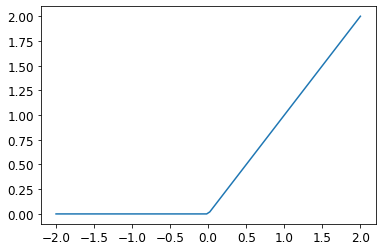

In [55]:
plot_function(F.relu)

In [56]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1))

All `nn.Sequential` does is create a model so we can call each layer in turn. Now let's convert the linear model to a neural network model and give it a smaller learning rate( since this is a deeper model).

In [57]:
learner = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
#everything except the SGD is 'home made'
learner.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.317200,0.411041,0.504907,00:00
1,0.144616,0.221571,0.813543,00:00
2,0.079456,0.109266,0.922964,00:00
3,0.052203,0.074251,0.943081,00:00
4,0.039732,0.058410,0.959274,00:00
5,0.033423,0.049514,0.965653,00:00
6,0.029829,0.043923,0.966634,00:00
7,0.027523,0.040106,0.968106,00:00
8,0.025874,0.037340,0.969578,00:00
9,0.024594,0.035239,0.970559,00:00


final accuracy 0.9838076829910278


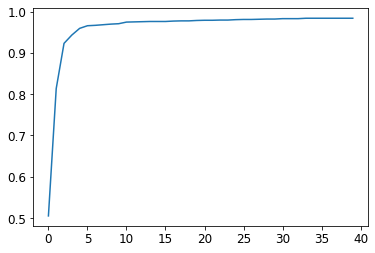

In [68]:
#pretty impressive results. We can get those results by calling learner.recorder
plt.plot(L(learner.recorder.values).itemgot(2))
print(f'final accuracy {learner.recorder.values[-1][2]}')

Here we can see the learning rate of the model. It's quite exponential and it is actually to be expected. Of course, on different datasets( when we go for the whole MNIST dataset) it will be different. But we'll pass that hurdle when we get there.

# Final thoughts
we've coded a neural model from scratch. I believe we've understood some fundamentally important aspects of model processing, Machine Learning and Neural Networks. The accuracy of the model is quite high for just 1-2 minutes of training AND this is a base and simple model. Using techniques that we can learn later on we'll improve these 'rookie' numbers. I look forward to that. 

To finish things off here is some jargon used daily in the ML world:
- ReLU - an activation function that sets negative values to 0 and leaves positive ones untouched
- activation function - a function that decides when a neuron should be activated /started
- mini-batch - a batch is a small collection of the data(ex. 256 items)
- forward pass - calculating the activation functions and loss for the layer
- loss - a metric used by the computer to calculate how accurate our model is
- gradient - the derivation of the loss function. This is used in the backward pass
- backward pass - calculating the gradient and changing the values of the parameters( weights and biases).. also called a step
- learning rate - the rate at which the system will learn.. higher values will make the model learn faster, but it is more prone to error and `bouncing`.. too small a value and you will never learn fast enough so the learning rate is a pretty important aspect of the model

I've added the graph that shows how the model learns. I cannot stress this enough, this is not a black box if you understand the concepts behind it. 

![](my_icons/title.PNG)